In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

import scipy.stats as ss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

C:\Users\Rakshith\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Rakshith\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Rakshith\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
df = pd.read_csv('C:\\Users\\Rakshith\\Downloads\\file\\Train_file.csv')

In [3]:
df.shape

(62288, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    62288 non-null  int64  
 1   Age                   62288 non-null  int64  
 2   Agency                62288 non-null  object 
 3   Agency Type           62288 non-null  object 
 4   Commision (in value)  62288 non-null  float64
 5   Destination           62288 non-null  object 
 6   Distribution Channel  62288 non-null  object 
 7   Duration              62288 non-null  int64  
 8   Gender                22713 non-null  object 
 9   Net Sales             62288 non-null  float64
 10  Product Name          62288 non-null  object 
 11  Claim                 62288 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 5.7+ MB


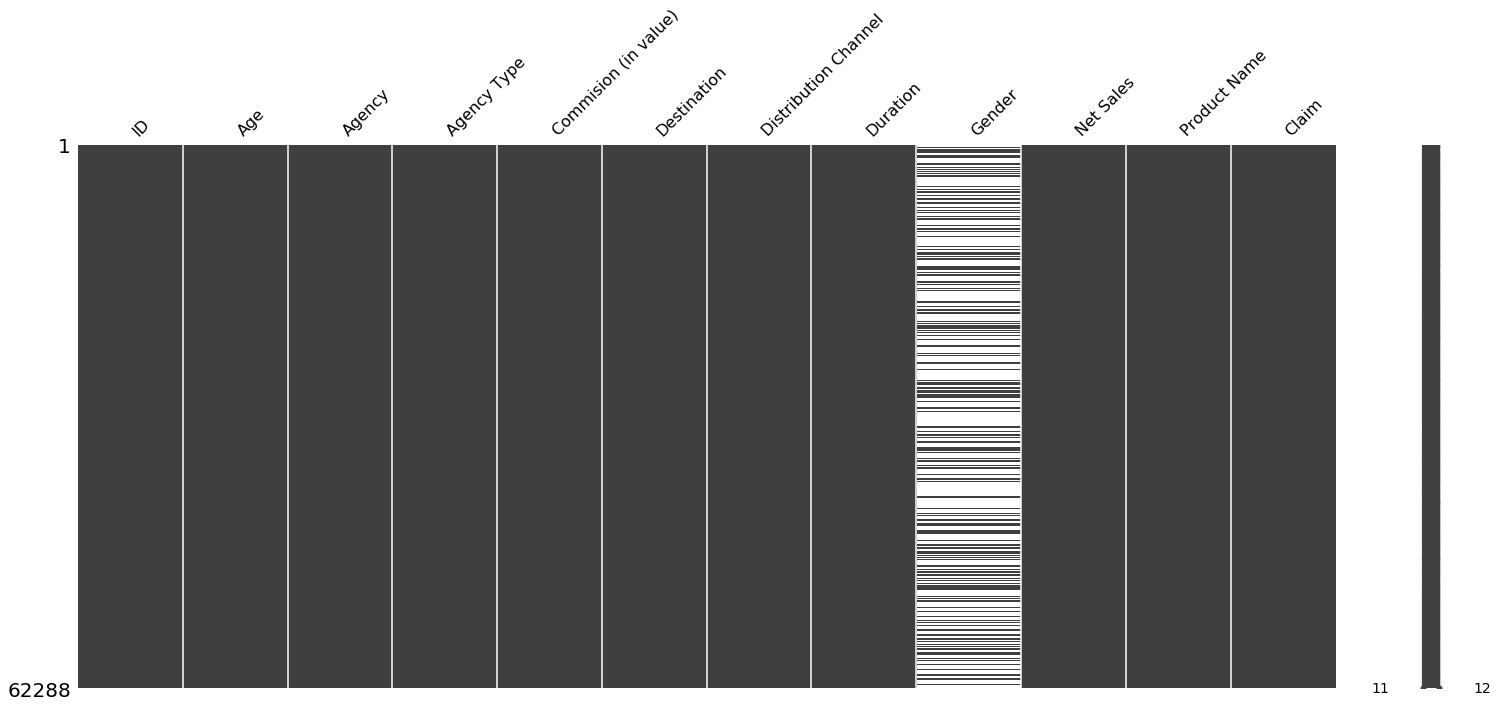

In [5]:
missingno.matrix(df)

In [6]:
df['Gender'].isnull().sum()

39575

In [7]:
df.fillna('Not Specified',inplace=True)

In [8]:
df.isnull().sum()

ID                      0
Age                     0
Agency                  0
Agency Type             0
Commision (in value)    0
Destination             0
Distribution Channel    0
Duration                0
Gender                  0
Net Sales               0
Product Name            0
Claim                   0
dtype: int64

In [9]:
df_numerical=df._get_numeric_data()
df_numerical.drop(['ID','Claim'],inplace = True,axis = 1)

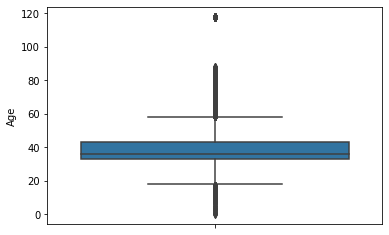

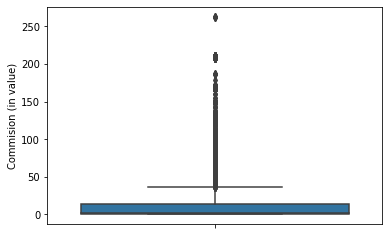

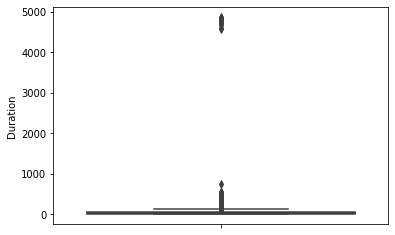

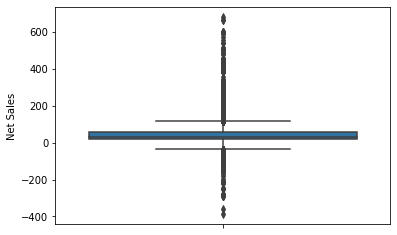

In [10]:
for i, col in enumerate(df_numerical.columns):
    plt.figure(i)
    sns.boxplot(y=df_numerical[col], data=df)
    #sns.distplot(df_numerical[col])

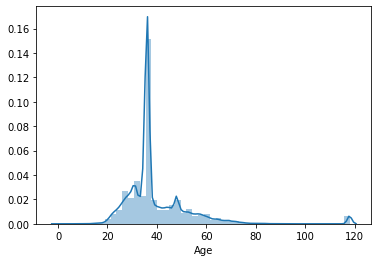

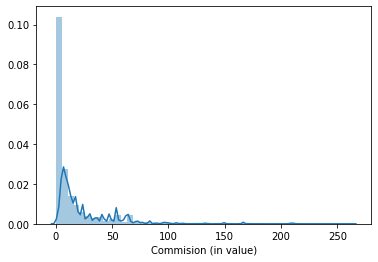

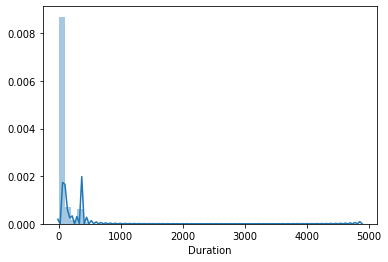

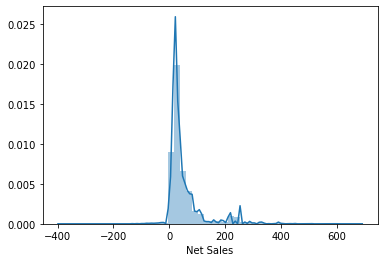

In [11]:
for i, col in enumerate(df_numerical.columns):
    plt.figure(i)
    #sns.boxplot(y=df_numerical[col], data=df)
    sns.distplot(df_numerical[col])

In [12]:
df['Net Sales'].describe()

count    62288.000000
mean        50.717064
std         63.166715
min       -389.000000
25%         20.000000
50%         29.700000
75%         58.000000
max        682.000000
Name: Net Sales, dtype: float64

In [13]:
df['Duration'].describe()

count    62288.000000
mean        60.958804
std        114.325330
min         -2.000000
25%         10.000000
50%         25.000000
75%         59.000000
max       4881.000000
Name: Duration, dtype: float64

In [14]:
df_d=df['Duration']<0
df_d.sum()

4

In [15]:
df['Duration'].mean()

60.9588042640637

In [16]:
df.loc[df['Duration'] < 0, 'Duration'] = 60.96

In [17]:
df_n= df['Net Sales']<df['Commision (in value)']
df_n.sum()

1667

In [18]:
#df.loc[df['Net Sales'] == 0.0, 'Commision (in value)'] = 0
df.loc[df['Net Sales'] == 0.0, 'Commision (in value)'] = 0

In [19]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))



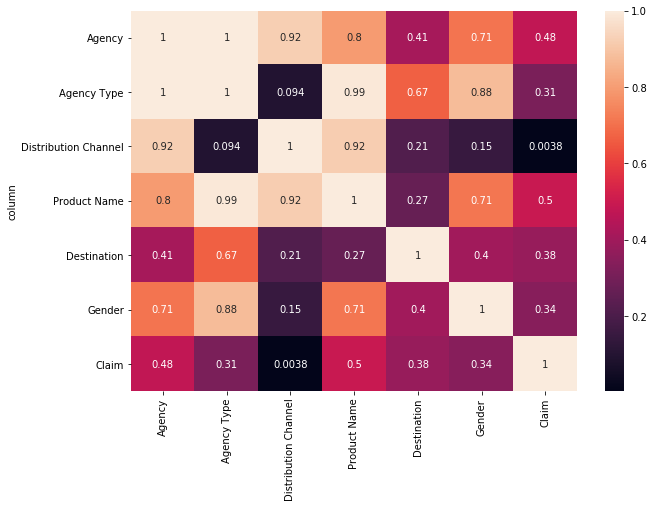

In [20]:
categorical=['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',  'Destination','Gender','Claim']
cramers=pd.DataFrame({i:[cramers_v(df[i],df[j]) for j in categorical] for i in categorical})
cramers['column']=[i for i in categorical if i not in ['memberid']]
cramers.set_index('column',inplace=True)

#categorical correlation heatmap

plt.figure(figsize=(10,7))
sns.heatmap(cramers,annot=True)
plt.show()

#### Can coclude that the cloumn "Agency Type' have high corelation with some of the columns like "Agency","Product Name" thus we can drop "Agency Type".

In [21]:
test=[(df[df['Gender']=='Not Specified']['Claim'].value_counts()/len(df[df['Gender']=='Not Specified']['Claim']))[1],(df[df['Gender']=='M']['Claim'].value_counts()/len(df[df['Gender']=='M']['Claim']))[1],
      (df[df['Gender']=='F']['Claim'].value_counts()/len(df[df['Gender']=='F']['Claim']))[1]]
test

[0.09672773215413771, 0.35248018523466024, 0.4068268895855103]

In [22]:
df.describe()

,ID,Age,Commision (in value),Duration,Net Sales,Claim
count,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000
mean,32844.953458,39.666324,12.353053,60.962799,50.717064,0.200006
std,18065.417216,14.014652,23.280680,114.324243,63.166715,0.400008
min,0.000000,0.000000,0.000000,0.000000,-389.000000,0.000000
25%,17579.000000,33.000000,0.000000,10.000000,20.000000,0.000000
50%,33446.500000,36.000000,0.000000,25.000000,29.700000,0.000000
75%,48532.250000,43.000000,13.250000,59.000000,58.000000,0.000000
max,63323.000000,118.000000,262.760000,4881.000000,682.000000,1.000000


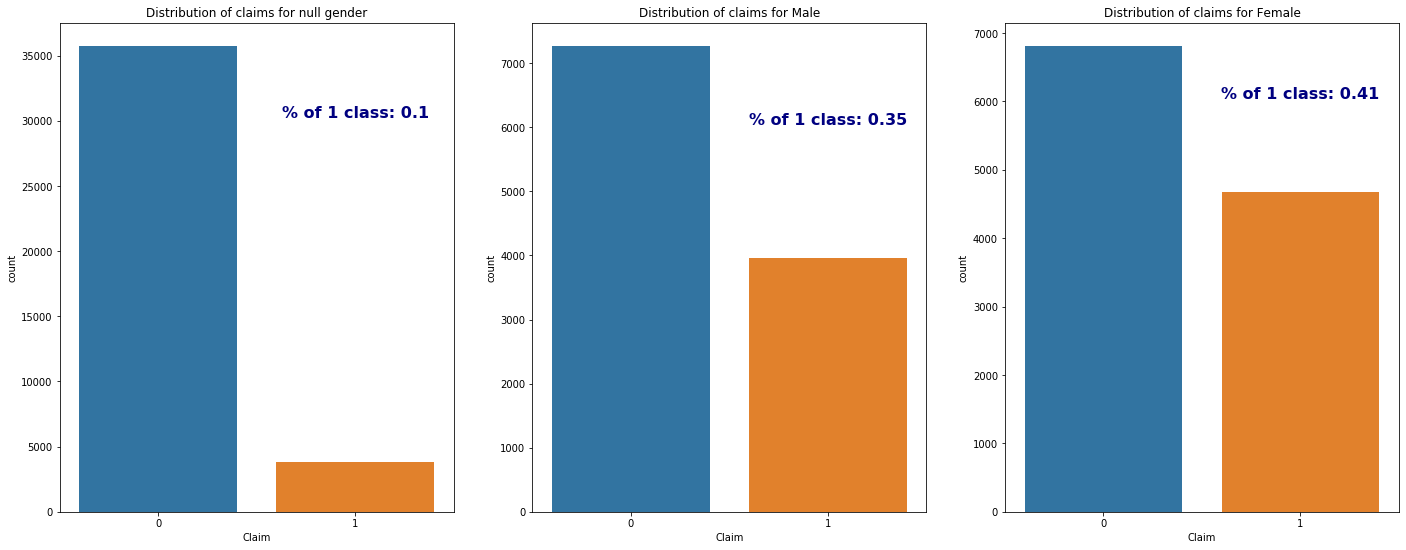

In [23]:
fig, axes=plt.subplots(1,3,figsize=(24,9))
sns.countplot(df[df['Gender']=='Not Specified']['Claim'],ax=axes[0])
axes[0].set(title='Distribution of claims for null gender')
axes[0].text(x=1,y=30000,s=f'% of 1 class: {round(test[0],2)}',fontsize=16,weight='bold',ha='center',va='bottom',color='navy')
sns.countplot(df[df['Gender']=='M']['Claim'],ax=axes[1])
axes[1].set(title='Distribution of claims for Male')
axes[1].text(x=1,y=6000,s=f'% of 1 class: {round(test[1],2)}',fontsize=16,weight='bold',ha='center',va='bottom',color='navy')
sns.countplot(df[df['Gender']=='F']['Claim'],ax=axes[2])
axes[2].set(title='Distribution of claims for Female')
axes[2].text(x=1,y=6000,s=f'% of 1 class: {round(test[2],2)}',fontsize=16,weight='bold',ha='center',va='bottom',color='navy')
plt.show()

In [24]:
pd.crosstab(df['Agency'],df['Agency Type'],margins=True)

Agency Type,Airlines,Travel Agency,All
Agency,,,
ADM,0,65,65
ART,271,0,271
C2B,13608,0,13608
CBH,0,99,99
CCR,0,211,211
CSR,0,75,75
CWT,0,7956,7956
EPX,0,30415,30415
JWT,639,0,639


In [25]:
table1=pd.crosstab(df['Agency'],df['Claim'],margins=True)

table1.drop(index=['All'],inplace=True)
table1=(table1.div(table1['All'],axis=0))*100

table1['mean commision']=df.groupby('Agency')['Commision (in value)'].mean()
table1

Claim,0,1,All,mean commision
Agency,,,,
ADM,100.000000,0.000000,100.0,32.434462
ART,95.571956,4.428044,100.0,9.969373
C2B,45.517343,54.482657,100.0,24.702354
CBH,85.858586,14.141414,100.0,9.243333
CCR,77.725118,22.274882,100.0,9.998531
CSR,82.666667,17.333333,100.0,10.463200
CWT,85.419809,14.580191,100.0,30.986403
EPX,91.550222,8.449778,100.0,0.000000
JWT,93.896714,6.103286,100.0,22.275430


In [26]:
table1.columns

Index([0, 1, 'All', 'mean commision'], dtype='object', name='Claim')

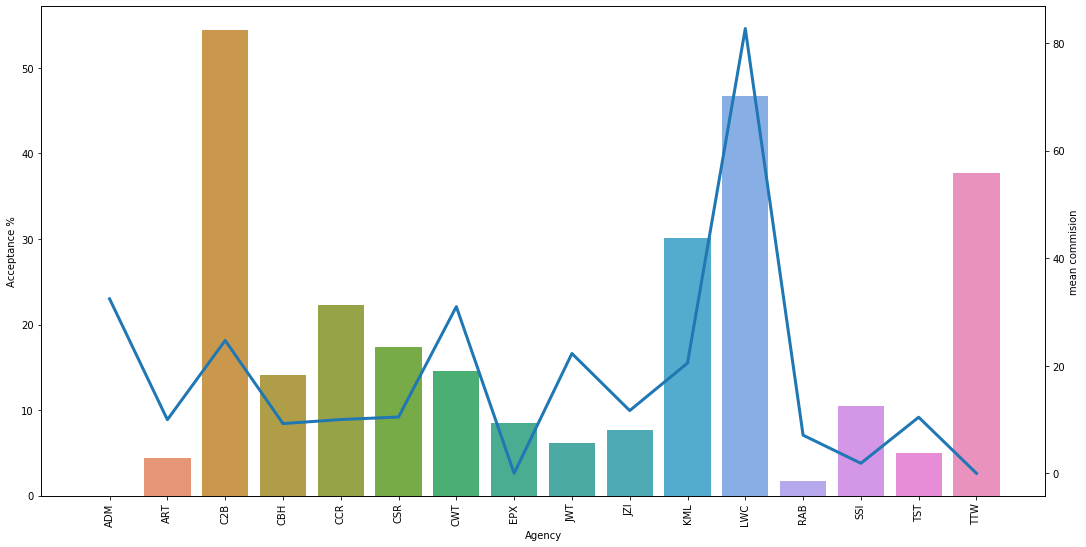

In [27]:
fig,ax1=plt.subplots(figsize=(18,9))
sns.barplot(table1.index,table1[1],ax=ax1)
plt.xticks(rotation=90)
ax1.set(ylabel='Acceptance %')
ax2=ax1.twinx()
sns.lineplot(table1.index,table1['mean commision'],ax=ax2,linewidth=3)

### X axis= Agency Name Y axis=Acceptance % line plot= Commision So we can see certain agencies have higher % of acceptance, C2B, LWC, TTW

In [28]:
table2=pd.crosstab(df['Product Name'],df['Claim'],margins=True)
table2=(table2.div(table2['All'],axis=0))*100

table2['mean commision']=df.groupby('Product Name')['Commision (in value)'].mean()
table2.drop(index=['All'],inplace=True)
table2

Claim,0,1,All,mean commision
Product Name,,,,
1 way Comprehensive Plan,95.760599,4.239401,100.0,0.000000
2 way Comprehensive Plan,84.943692,15.056308,100.0,0.000000
24 Protect,100.000000,0.000000,100.0,7.593264
Annual Gold Plan,33.649289,66.350711,100.0,86.137962
Annual Silver Plan,32.166720,67.833280,100.0,57.804995
Annual Travel Protect Gold,37.878788,62.121212,100.0,163.344444
Annual Travel Protect Platinum,52.631579,47.368421,100.0,213.331579
Annual Travel Protect Silver,52.343750,47.656250,100.0,133.922422
Basic Plan,93.054662,6.945338,100.0,9.413612


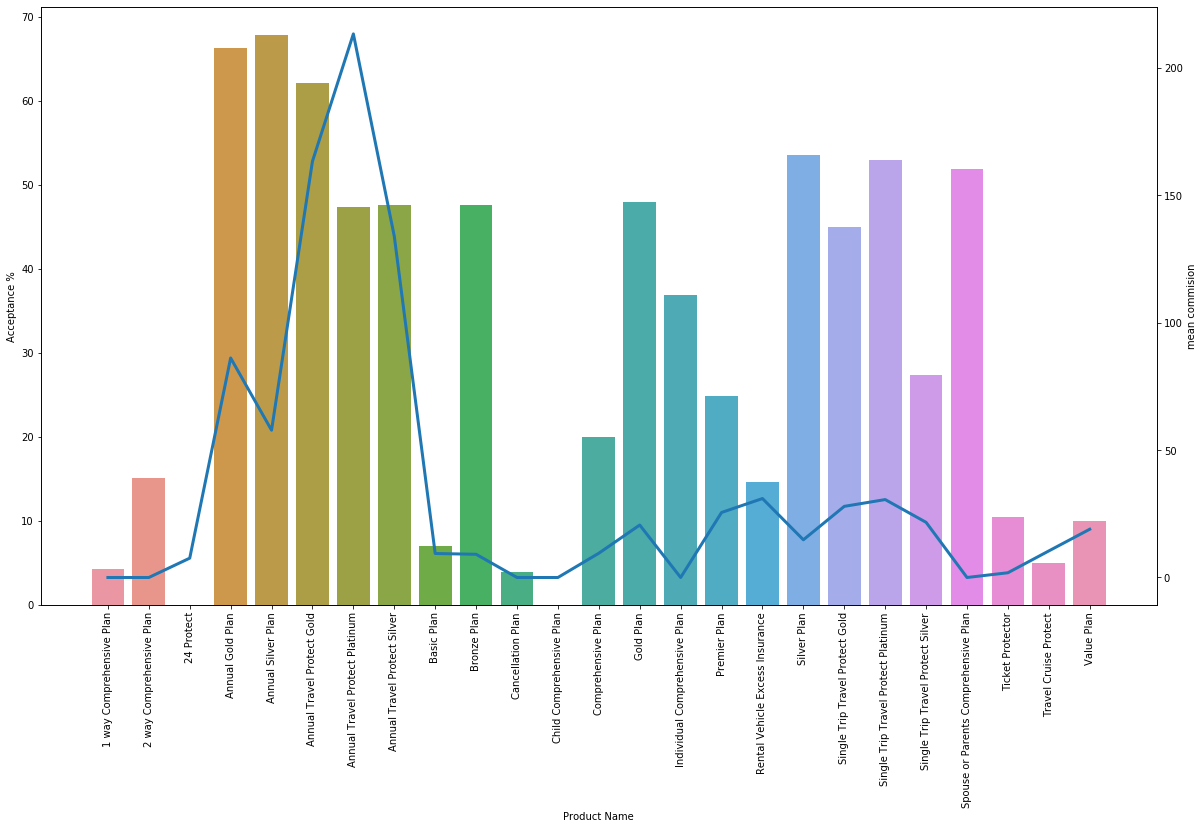

In [29]:
fig,ax1=plt.subplots(figsize=(20,11))
sns.barplot(table2.index,table2[1],ax=ax1)
plt.xticks(rotation=90)
ax1.set(ylabel='Acceptance %')
ax2=ax1.twinx()
sns.lineplot(table2.index,table2['mean commision'],ax=ax2,linewidth=3)

#### Some of the products with high commission have a high ratio of claims acceptance. The plans with zero commission generally have low acceptance

In [30]:
len(df['Duration'].unique())

442

In [31]:
tests=df.copy()
tests['Duration_label']=pd.qcut(df['Duration'],q=35, duplicates='drop')
table3=pd.crosstab(tests['Duration_label'],tests['Claim'],normalize='index')
table3

Claim,0,1
Duration_label,,
"(-0.001, 2.0]",0.955388,0.044612
"(2.0, 4.0]",0.918329,0.081671
"(4.0, 5.0]",0.887634,0.112366
"(5.0, 6.0]",0.855290,0.144710
"(6.0, 7.0]",0.891033,0.108967
"(7.0, 8.0]",0.817256,0.182744
"(8.0, 9.0]",0.830912,0.169088
"(9.0, 10.0]",0.791270,0.208730
"(10.0, 12.0]",0.821622,0.178378


In [32]:
table3.columns

Int64Index([0, 1], dtype='int64', name='Claim')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

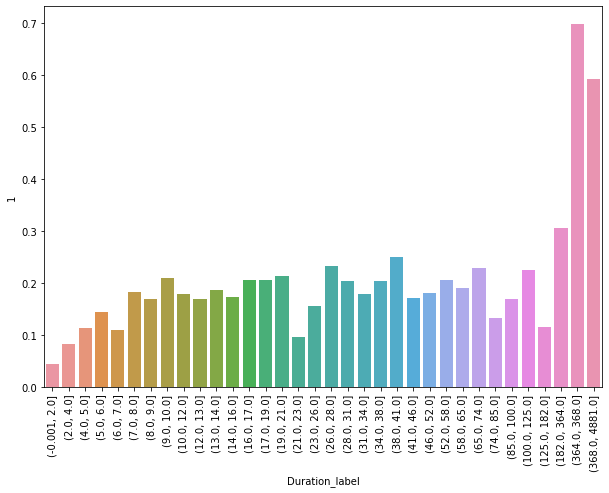

In [33]:
plt.figure(figsize=(10,7))
sns.barplot(table3.index,table3[1])
plt.xticks(rotation=90)

#### On varying the value of bins, we found that Durations>364 have a high percentage of acceptance compared to the rest.

In [34]:
table4=pd.crosstab(df['Destination'],df['Claim'],margins=True,normalize='index')
table4

Claim,0,1
Destination,,
ARGENTINA,0.555556,0.444444
AUSTRALIA,0.844100,0.155900
AUSTRIA,1.000000,0.000000
AZERBAIJAN,1.000000,0.000000
BAHRAIN,1.000000,0.000000
...,...,...
VANUATU,1.000000,0.000000
VENEZUELA,1.000000,0.000000
VIET NAM,0.891048,0.108952


In [35]:
table4 = table4.sort_values(by=[1], ascending=[False])
table4

Claim,0,1
Destination,,
COSTA RICA,0.250000,0.750000
ARGENTINA,0.555556,0.444444
SINGAPORE,0.572095,0.427905
CZECH REPUBLIC,0.658537,0.341463
SOUTH AFRICA,0.719512,0.280488
...,...,...
MEXICO,1.000000,0.000000
MONGOLIA,1.000000,0.000000
MOROCCO,1.000000,0.000000


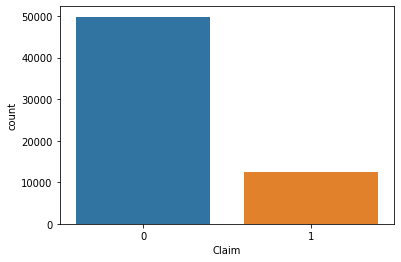

In [36]:
sns.countplot(df['Claim'])

#### From the above graph we can say that there is high imbalance in the target variable


In [37]:
class ChiSquare:
    def __init__(self, df):
        self.df = df
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = ss.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [38]:
X = df.drop(['Claim'], axis=1)
ct = ChiSquare(df)
for c in X.columns:
    ct.TestIndependence(c, 'Claim')

ID is IMPORTANT for Prediction
Age is IMPORTANT for Prediction
Agency is IMPORTANT for Prediction
Agency Type is IMPORTANT for Prediction
Commision (in value) is IMPORTANT for Prediction
Destination is IMPORTANT for Prediction
Distribution Channel is NOT an important predictor. (Discard Distribution Channel from model)
Duration is IMPORTANT for Prediction
Gender is IMPORTANT for Prediction
Net Sales is IMPORTANT for Prediction
Product Name is IMPORTANT for Prediction


In [39]:
df.drop(columns=['ID','Distribution Channel','Agency Type'],axis=1,inplace=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   62288 non-null  int64  
 1   Agency                62288 non-null  object 
 2   Commision (in value)  62288 non-null  float64
 3   Destination           62288 non-null  object 
 4   Duration              62288 non-null  float64
 5   Gender                62288 non-null  object 
 6   Net Sales             62288 non-null  float64
 7   Product Name          62288 non-null  object 
 8   Claim                 62288 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 4.3+ MB


In [41]:
df.shape

(62288, 9)

In [42]:
df.head()

,Age,Agency,Commision (in value),Destination,Duration,Gender,Net Sales,Product Name,Claim
0,28,C2B,28.13,SINGAPORE,34.0,F,112.5,Silver Plan,1
1,37,JZI,12.95,PHILIPPINES,53.0,F,37.0,Basic Plan,0
2,27,EPX,0.00,UNITED STATES,28.0,Not Specified,13.0,Cancellation Plan,0
3,36,EPX,0.00,SAUDI ARABIA,1.0,Not Specified,34.0,Cancellation Plan,0
4,26,CWT,23.76,THAILAND,33.0,Not Specified,39.6,Rental Vehicle Excess Insurance,0


In [43]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['Agency']= label_encoder.fit_transform(df['Agency']) 
  
df['Destination']= label_encoder.fit_transform(df['Destination']) 
df['Gender']= label_encoder.fit_transform(df['Gender']) 
df['Product Name']= label_encoder.fit_transform(df['Product Name']) 
  

In [44]:
df = pd.get_dummies(df)

In [45]:
df.head()

,Age,Agency,Commision (in value),Destination,Duration,Gender,Net Sales,Product Name,Claim
0,28,2,28.13,79,34.0,0,112.5,17,1
1,37,9,12.95,72,53.0,0,37.0,8,0
2,27,7,0.00,96,28.0,2,13.0,10,0
3,36,7,0.00,78,1.0,2,34.0,10,0
4,26,6,23.76,88,33.0,2,39.6,16,0


In [46]:
conda install -c anaconda py-xgboost


Note: you may need to restart the kernel to use updated packages.



CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/anaconda/win-64/repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
'https://conda.anaconda.org/anaconda/win-64'




In [47]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [48]:
X = df.drop(['Claim'], axis = 1)
y = df["Claim"]

In [49]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [51]:
ada =AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, random_state=None)
ada.fit(X_train,y_train)
ada_pred = ada.predict(X_test)
accuracy = accuracy_score(y_test, ada_pred)
accuracy
                        

0.8405843634612298

In [52]:
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
accuracy = accuracy_score(y_test, preds)
accuracy

0.8276609407609569

In [53]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      9994
           1       0.70      0.22      0.34      2464

    accuracy                           0.83     12458
   macro avg       0.77      0.60      0.62     12458
weighted avg       0.81      0.83      0.79     12458



In [54]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
print(pred)
lr.score(X_test,y_test)
print(classification_report(y_test, pred))


[0 0 0 ... 0 1 0]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      9994
           1       0.63      0.30      0.41      2464

    accuracy                           0.83     12458
   macro avg       0.74      0.63      0.65     12458
weighted avg       0.80      0.83      0.80     12458



C:\Users\Rakshith\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [55]:
accuracy = accuracy_score(y_test, pred)
accuracy

0.8266174345801894

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9994
           1       0.96      1.00      0.98      2464

    accuracy                           0.99     12458
   macro avg       0.98      1.00      0.99     12458
weighted avg       0.99      0.99      0.99     12458



In [57]:
accuracy = accuracy_score(y_test, rf_pred)
accuracy

0.9922138384973511

In [60]:
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)



print("Classification Report")
print(classification_report(y_test,predictions))
accuracy = accuracy_score(y_test, predictions)
accuracy

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      9994
           1       0.63      0.44      0.52      2464

    accuracy                           0.84     12458
   macro avg       0.75      0.69      0.71     12458
weighted avg       0.82      0.84      0.83     12458



0.8386578905121207

In [60]:
df1 = pd.read_csv('C:/Users/hp/Desktop/python2/Hackathon/Test_file.csv')
df1.fillna('Not Specified',inplace=True)
ID = df1['ID']
df1.drop(['ID','Agency Type','Distribution Channel'],axis = 1 , inplace = True)
#df1 = pd.get_dummies(df1, columns=['Destination','Gender','Agency','Product Name'], drop_first=True)
from sklearn import preprocessing

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df1['Agency']= label_encoder.fit_transform(df1['Agency']) 
  
df1['Destination']= label_encoder.fit_transform(df1['Destination']) 
df1['Gender']= label_encoder.fit_transform(df1['Gender']) 
df1['Product Name']= label_encoder.fit_transform(df1['Product Name']) 

In [61]:
df1 = pd.get_dummies(df1)

### XG_Boosting

In [71]:

test_predictions = rf_pred.predict  (X1)



print("Classification Report")
print(classification_report(y_test, test_predictions[0:12458]))

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      9994
           1       0.21      0.15      0.18      2464

   micro avg       0.72      0.72      0.72     12458
   macro avg       0.51      0.50      0.50     12458
weighted avg       0.69      0.72      0.70     12458



### Best result by Random Forest 

In [74]:
pred_data=pd.DataFrame(pred_rf,columns = ['Claim'])
pred_id = pd.merge(ID,pred_data,left_on=None, right_on=None, left_index=True, right_index=True)
pred_id.to_csv('Filepred2_rf.csv' ,index=False)
pred_id

,ID,Claim
0,26611,0
1,50772,0
2,59472,0
3,5466,0
4,61014,1
5,22144,0
6,60735,1
7,57885,0
8,50175,1
9,51305,0
